In [69]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive


In [70]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import davies_bouldin_score

# Load Dataset

In [71]:
df_agg = pd.read_csv("Aggregation.txt", header=None, sep=" ")
df_d31 = pd.read_csv("D31.txt", header=None, sep=" ")
df_r15 = pd.read_csv("R15.txt", header=None, sep=" ")

# Show Dataset Distribution

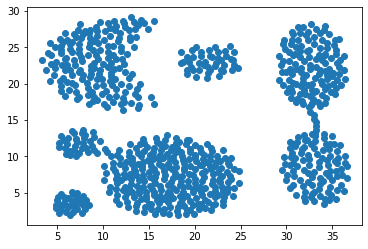

In [72]:
plt.scatter(df_agg[0], df_agg[1])

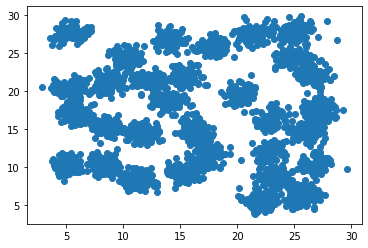

In [73]:
plt.scatter(df_d31[0], df_d31[1])

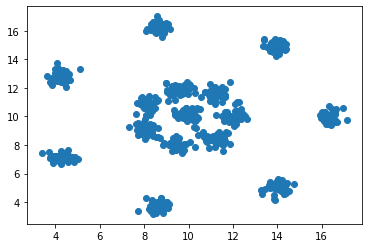

In [74]:
plt.scatter(df_r15[0], df_r15[1])

# DesintyPeaksClustering Model

In [75]:
class DensityPeaksClustering:
    def __init__(self, d_c):
        self.d_c = d_c

    def getDistance(self):
        num, _ = np.shape(self.dataset)
        self.distance = np.zeros((num, num))
        for i in range(num):
            for j in range(i + 1, num):
                self.distance[i][j] = np.sqrt(np.sum(np.square(self.dataset[i] - self.dataset[j])))
                self.distance[j][i] = self.distance[i][j]

    def getRho(self):
        num, _ = np.shape(self.dataset)
        self.rho = np.zeros(num)
        for i in range(num):
            # exclude itself
            self.rho[i] = np.where(self.distance[i, :] < self.d_c)[0].shape[0] - 1

    def getDelta(self):
        num, _ = np.shape(self.dataset)
        self.delta = np.zeros(num)
        self.nearest = np.zeros(num, dtype=np.int32)
        rho_index_sorted = np.argsort(-self.rho)
        for seq, i in enumerate(rho_index_sorted):
            if seq == 0:
                continue
            j = rho_index_sorted[: seq]
            self.delta[i] = np.min(self.distance[i][j])
            nearest_index = np.argmin(self.distance[i][j])
            self.nearest[i] = j[nearest_index]
        self.delta[rho_index_sorted[0]] = np.max(self.distance[i])

    def getGamma(self):
        self.gamma = self.rho * self.delta
        self.gamma_index = np.argsort(-self.gamma)

    def fit(self, dataset, cluster_num=None, rho=None, delta=None):
        self.dataset = dataset
        self.getDistance()
        self.getRho()
        self.getDelta()
        self.getGamma()
        self.bound = (rho, delta)
        num, _ = np.shape(self.dataset)
        self.category = np.zeros(num)
        self.center = np.zeros(num)
        self.center_index = []
        current_category = 1
        for seq, i in enumerate(self.gamma_index):
            if cluster_num and seq >= cluster_num:
                break
            elif rho and delta and not(self.rho[i] >= rho and self.delta[i] >= delta):
                break
            self.category[i] = current_category
            self.center[i] = current_category
            self.center_index.append(i)
            current_category = current_category + 1
        
        rho_index_sorted = np.argsort(-self.rho)
        for i in rho_index_sorted:
            if self.category[i] == 0:
                self.category[i] = self.category[self.nearest[i]]

    def drawDecisionGraph(self):
        plt.title("Decision Graph")
        plt.xlabel(r"$\rho$")
        plt.ylabel(r"$\delta$")
        plt.scatter(self.rho, self.delta, c=self.center)
        if self.bound != (None, None):
            plt.axhline(y=self.bound[1])
            plt.axvline(x=self.bound[0])

    def drawCluster(self):
        plt.title("Cluster")
        plt.scatter(self.dataset[:, 0], self.dataset[:, 1], c=self.category)
        for i in self.center_index:
            plt.scatter(self.dataset[i][0], self.dataset[i][1], marker="x", c="red")

    def drawGamma(self):
        plt.title(r"$\gamma\ Distribution$")
        plt.xlabel("number")
        plt.ylabel(r"$\gamma$")
        plt.scatter(np.arange(len(self.gamma_index)), self.gamma[self.gamma_index])
        plt.scatter(np.arange(len(self.center_index)), self.gamma[self.center_index], marker="o", c="red")

# Training

当直接采用 `cluster_num` 来进行训练

In [76]:
model_agg = DensityPeaksClustering(d_c=0.05)
dataset_agg = np.array((df_agg - df_agg.min()) / (df_agg.max() - df_agg.min()))
model_agg.fit(dataset_agg, cluster_num=7)

In [77]:
model_d31 = DensityPeaksClustering(d_c=0.05)
dataset_d31 = np.array((df_d31 - df_d31.min()) / (df_d31.max() - df_d31.min()))
model_d31.fit(dataset_d31, cluster_num=31)

In [78]:
model_r15 = DensityPeaksClustering(d_c=0.05)
dataset_r15 = np.array((df_r15 - df_r15.min()) / (df_r15.max() - df_r15.min()))
model_r15.fit(dataset_r15, cluster_num=15)

选取较高的 $\rho$ 和较大的 $\delta$ 来选取聚类中心

In [79]:
model2_agg = DensityPeaksClustering(d_c=0.05)
dataset_agg = np.array((df_agg - df_agg.min()) / (df_agg.max() - df_agg.min()))
model2_agg.fit(dataset_agg, cluster_num=None, rho=13, delta=0.2)

In [80]:
model2_d31 = DensityPeaksClustering(d_c=0.05)
dataset_d31 = np.array((df_d31 - df_d31.min()) / (df_d31.max() - df_d31.min()))
model2_d31.fit(dataset_d31, cluster_num=None, rho=65, delta=0.08)

In [81]:
model2_r15 = DensityPeaksClustering(d_c=0.05)
dataset_r15 = np.array((df_r15 - df_r15.min()) / (df_r15.max() - df_r15.min()))
model2_r15.fit(dataset_r15, cluster_num=None, rho=33, delta=0.08)

# Visualization

对 `model_agg` 进行可视化

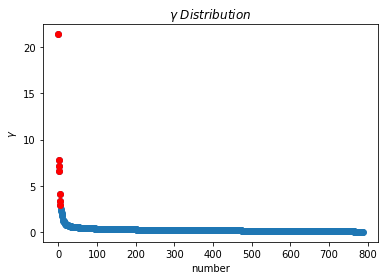

In [82]:
model_agg.drawGamma()

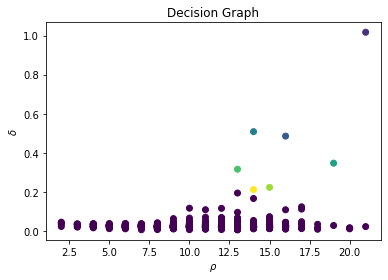

In [83]:
model_agg.drawDecisionGraph()

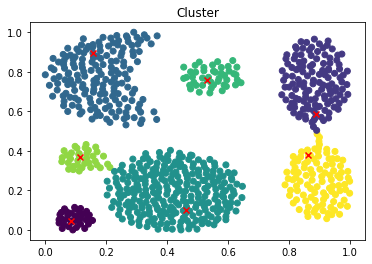

In [84]:
model_agg.drawCluster()

对 `model_d31` 进行可视化

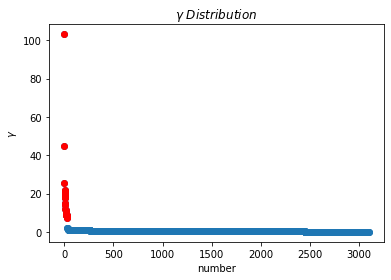

In [85]:
model_d31.drawGamma()

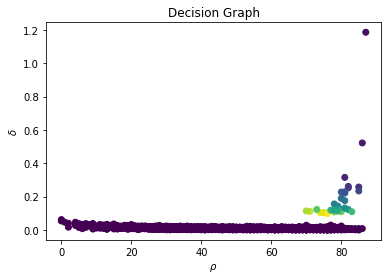

In [86]:
model_d31.drawDecisionGraph()

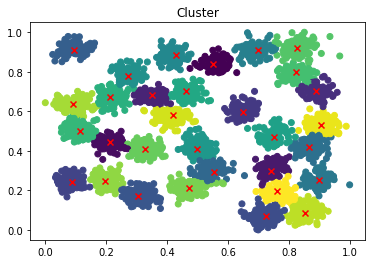

In [87]:
model_d31.drawCluster()

对 `model_r15` 进行可视化

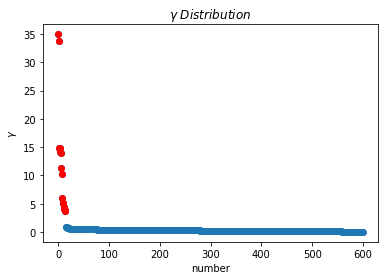

In [88]:
model_r15.drawGamma()

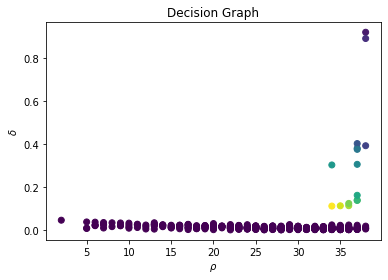

In [89]:
model_r15.drawDecisionGraph()

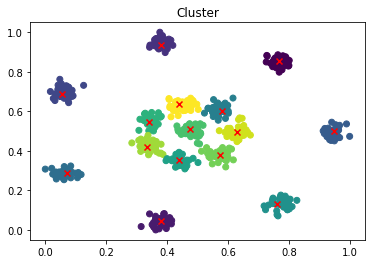

In [90]:
model_r15.drawCluster()

对 `model2_agg` 进行可视化

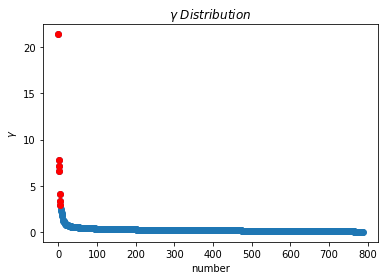

In [91]:
model2_agg.drawGamma()

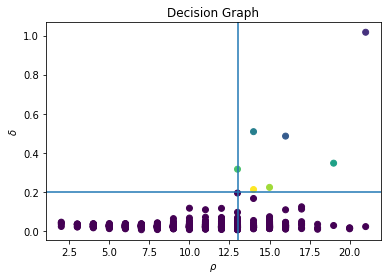

In [92]:
model2_agg.drawDecisionGraph()

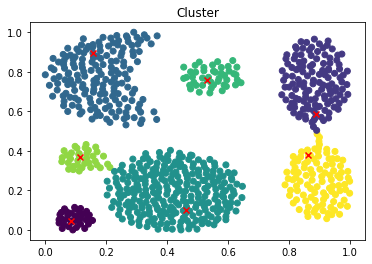

In [93]:
model2_agg.drawCluster()

对 `model2_d31` 进行可视化

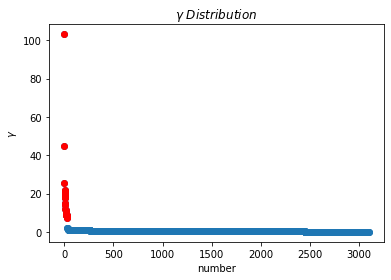

In [94]:
model2_d31.drawGamma()

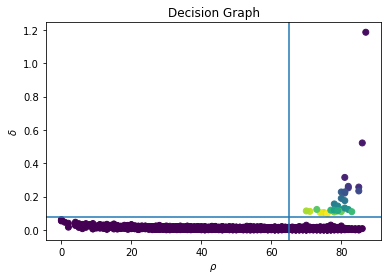

In [95]:
model2_d31.drawDecisionGraph()

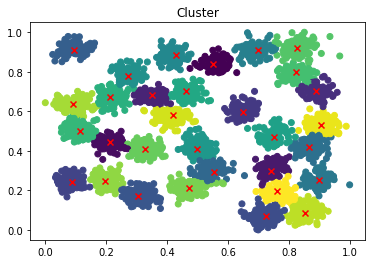

In [96]:
model2_d31.drawCluster()

对 `model2_r15` 进行可视化

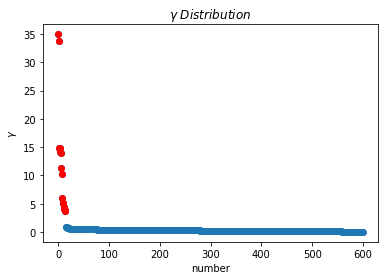

In [97]:
model2_r15.drawGamma()

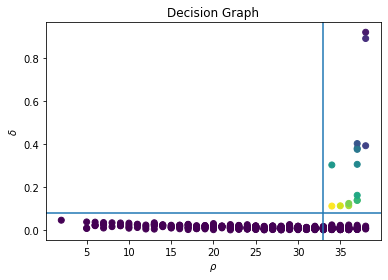

In [98]:
model2_r15.drawDecisionGraph()

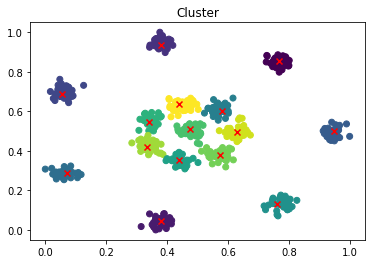

In [99]:
model2_r15.drawCluster()

# Evaluate

计算出三个模型的 DBI 值

In [100]:
print(davies_bouldin_score(df_agg, model_agg.category))
print(davies_bouldin_score(df_d31, model_d31.category))
print(davies_bouldin_score(df_r15, model_r15.category))

0.506748058104934
0.5528666031397756
0.31481596929442923


In [101]:
print(davies_bouldin_score(df_agg, model2_agg.category))
print(davies_bouldin_score(df_d31, model2_d31.category))
print(davies_bouldin_score(df_r15, model2_r15.category))

0.506748058104934
0.5528666031397756
0.31481596929442923
